# (13) Samples -- fixate-1/cNVAE/VAE

**Motivation**: But other usages as well, such as PSTH. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# Code path
sys.path.insert(0, '/home/hadi/Documents/MTMST/code')
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Load models

In [2]:
fits = [
    'fixate1_nf-420_beta-0.15_(2023_04_27,20:20)',
    'vanilla_fixate1_nf-420_beta-1.5_(2023_05_14,14:16)',
]
trainers = {}
for fit in fits:
    model_name = extract_info(fit)[-1]
    trainers[model_name] = load_model_lite(
        path=pjoin(results_dir(), fit, 'Trainer'),
        device='cuda',
        strict=True,
    )[0]

## Generate samples

In [3]:
selected = {
    'cNVAE': [1, 2, 3, 8, 13],
    'VAE': range(5),
}
samples = {}
for model_name, ids in selected.items():
    x, _ = trainers[model_name].sample(16)
    samples[model_name] = to_np(x[ids])
samples = np.stack(list(samples.values()))

In [4]:
ids = [0, 2, 5, 11, 13]
rofl = trainers['cNVAE'].dl_tst.dataset.x
rofl = np.expand_dims(to_np(rofl[ids]), 0)

In [5]:
x = np.concatenate([rofl, samples])

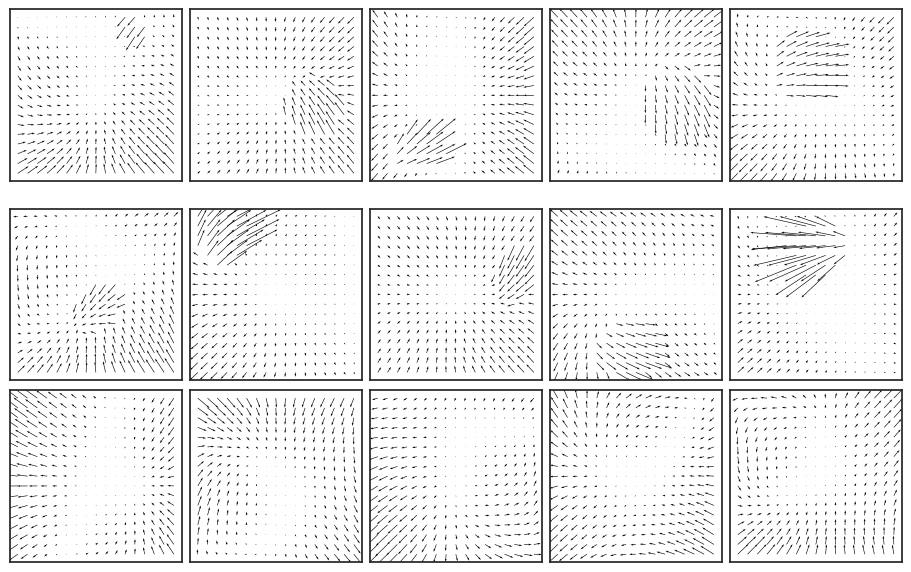

In [6]:
fig, axes = show_opticflow_row(
    x,
    figsize=(9, 5.8),
    height_ratios=[1.2, 1, 1],
)

In [15]:
fig.savefig(pjoin(fig_base_dir, 'samples.pdf'), bbox_inches='tight')

## Palette

In [7]:
pal, _ = get_palette()
pal = {
    k: rgb2hex(v) for
    k, v in pal.items()
}

In [8]:
print(pal)

{'cNVAE': '#4878d0', 'VAE': '#ee854a', 'cNAE': '#6f6f6f', 'AE': '#aeaeae'}

## Test NVAE latent space cfg

In [2]:
model_name = 'fixate1_k-32_z-1x[2,3,6]_enc(3x3)-dec(2x2)-pre(1x3)-post(1x3)_noncmprs'
fit_name = 'NVAE_ep160-b600-lr(0.002)_beta(0.15:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_08_07,10:30)'

tr = load_model(model_name, fit_name, device='cuda')[0]

In [8]:
print(tr.model.latent_scales())

(
    [2, 2, 4, 4, 4, 8, 8, 8, 8, 8, 8],
    {
        'idx-0_scale-2_group-0': range(0, 1),
        'idx-1_scale-2_group-1': range(1, 2),
        'idx-2_scale-4_group-0': range(2, 3),
        'idx-3_scale-4_group-1': range(3, 4),
        'idx-4_scale-4_group-2': range(4, 5),
        'idx-5_scale-8_group-0': range(5, 6),
        'idx-6_scale-8_group-1': range(6, 7),
        'idx-7_scale-8_group-2': range(7, 8),
        'idx-8_scale-8_group-3': range(8, 9),
        'idx-9_scale-8_group-4': range(9, 10),
        'idx-10_scale-8_group-5': range(10, 11)
    }
)

In [14]:
tr.model.total_latents()

440

## PSTH

In [81]:
f = h5py.File('/home/hadi/Documents/MTMST/data/DATA.h5')
print(f['ROOT'].keys())
g = f['ROOT']['clu090']
stim, spks, mask, stim_r, spks_r, good_r = load_ephys(g)
f.close()

<KeysViewHDF5 ['clu036', 'clu037', 'clu038', 'clu039', 'clu040', 'clu043', 'clu044', 
'clu053', 'clu055', 'clu059', 'clu061', 'clu064', 'clu068', 'clu069', 'clu081', 'clu082', 
'clu087', 'clu088', 'clu089', 'clu090', 'clu095', 'clu096', 'clu099', 'clu104', 'clu107', 
'clu108', 'clu109', 'clu110', 'clu116', 'clu120', 'clu126', 'clu131', 'clu132', 'clu142', 
'clu145', 'clu146', 'clu147', 'clu148', 'clu180', 'clu181', 'clu183', 'clu209', 'clu216', 
'clu221', 'clu222', 'clu223', 'clu224', 'clu225', 'clu226', 'clu227', 'clu229', 'clu267', 
'clu292', 'clu293', 'clu294', 'clu295', 'ytu021', 'ytu023', 'ytu028', 'ytu029']>

In [83]:
spks_r.shape

(1, 144, 200)

In [84]:
cell = 0
x = spks_r[cell]
x.shape

(144, 200)

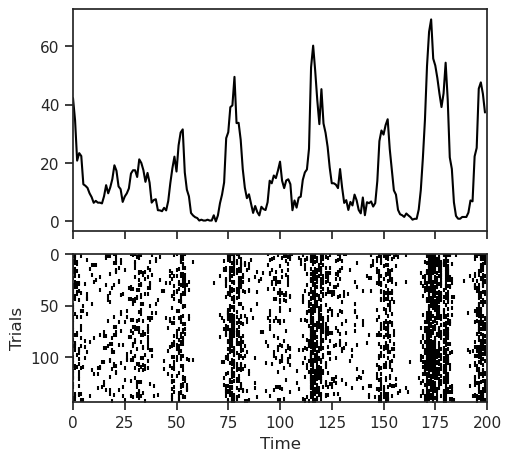

In [85]:
indices = np.argwhere(x > 1)

# Plot the raster plot
fig, axes = create_figure(2, 1, (5, 4.5), 'all', layout='constrained', height_ratios=[1.5, 1])
axes[0].plot(np.nanmean(x, 0) / 25e-3, color='k')
axes[1].scatter(indices[:, 1], indices[:, 0], marker='|', color='k', s=10, alpha=1)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Trials')
axes[1].set_xlim(0, x.shape[1])
axes[1].set_ylim(0, x.shape[0])
axes[1].invert_yaxis()
plt.show()

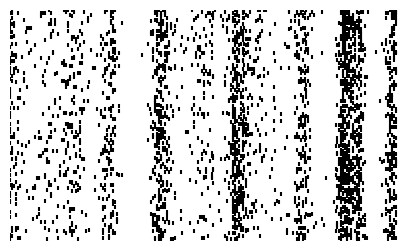

In [88]:
fig, ax = create_figure(1, 1, (5, 3))
ax.scatter(indices[:, 1], indices[:, 0], marker='|', color='k', s=10, alpha=1)
# ax.set_xlabel('Time')
# ax.set_ylabel('Trials')
ax.set_xlim(0, x.shape[1])
ax.set_ylim(0, x.shape[0])
ax.invert_yaxis()
remove_ticks(ax)
plt.show()

In [89]:
kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}
fig.savefig(pjoin(fig_base_dir, 'spk_counts.pdf'), **kws_fig)

In [67]:
r = 1 - sp_dist.cdist(
    x, np.nanmean(x, 0, keepdims=True),
    metric='correlation'
).ravel()
best_trial = np.nanargmax(r)
best_trial

11

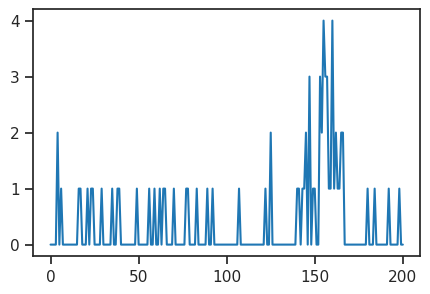

In [68]:
a = x[best_trial]
plt.plot(a);

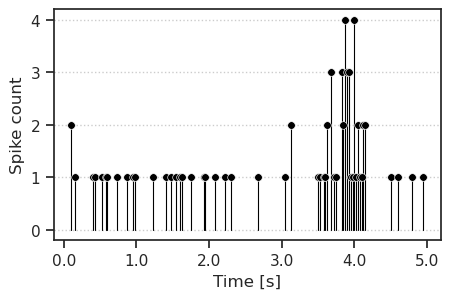

In [69]:
fig, ax = create_figure(1, 1, (5, 3))

for i, value in enumerate(a):
    if value > 0:
        ax.axvline(
            x=i,
            ymin=(0 + 0.2) / 4.4,
            ymax=(value + 0.2) / 4.4,
            color='k',
            lw=0.8,
            linestyle='-',
            zorder=1,
        )
_a = a.copy()
_a[a == 0.0] = np.nan
sns.scatterplot(x=range(len(a)), y=_a, marker='o', color='k', s=30, ax=ax)
ax.set_ylim(-0.2, 4.2)

xticks = [i for i in range(201) if i % 40 == 0]
ax.set(xticks=xticks, xticklabels=[i * 25e-3 for i in xticks])
ax.set_ylabel('Spike count')
ax.set_xlabel('Time [s]')

ax.grid(axis='y')

plt.show()

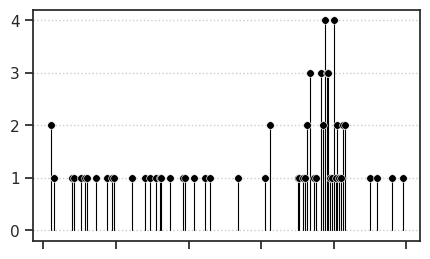

In [71]:
fig, ax = create_figure(1, 1, (5, 3))

for i, value in enumerate(a):
    if value > 0:
        ax.axvline(
            x=i,
            ymin=(0 + 0.2) / 4.4,
            ymax=(value + 0.2) / 4.4,
            color='k',
            lw=0.8,
            linestyle='-',
            zorder=1,
        )
_a = a.copy()
_a[a == 0.0] = np.nan
sns.scatterplot(x=range(len(a)), y=_a, marker='o', color='k', s=30, ax=ax)
ax.set_ylim(-0.2, 4.2)

xticks = [i for i in range(201) if i % 40 == 0]
ax.set(xticks=xticks, xticklabels=[])
ax.grid(axis='y')

plt.show()

In [72]:
kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}
fig.savefig(pjoin(fig_base_dir, 'spk_counts.pdf'), **kws_fig)

In [17]:
x = spks[:, 4]
x.shape

(43200,)

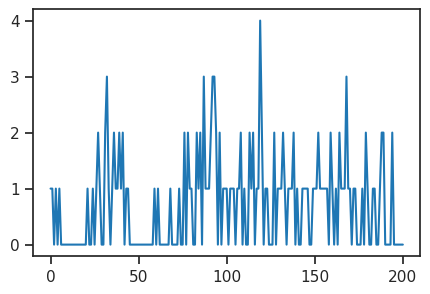

In [61]:
i = 2000
a = x[range(i, i+201)]
plt.plot(a);

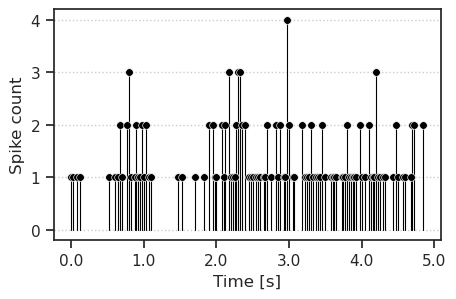

In [62]:
fig, ax = create_figure(1, 1, (5, 3))

for i, value in enumerate(a):
    if value > 0:
        ax.axvline(
            x=i,
            ymin=(0 + 0.2) / 4.4,
            ymax=(value + 0.2) / 4.4,
            color='k',
            lw=0.8,
            linestyle='-',
            zorder=1,
        )
_a = a.copy()
_a[a == 0.0] = np.nan
sns.scatterplot(x=range(len(a)), y=_a, marker='o', color='k', s=30, ax=ax)
ax.set_ylim(-0.2, 4.2)

xticks = [i for i in range(len(a)) if i % 40 == 0]
ax.set(xticks=xticks, xticklabels=[i * 25e-3 for i in xticks])
ax.set_ylabel('Spike count')
ax.set_xlabel('Time [s]')

ax.grid(axis='y')

plt.show()

## STA

In [3]:
path = pjoin(tmp_dir, 'neural_analysis')

selected_fits = [
    'fixate1_nf-420_beta-0.01_(2023_04_30,07:42).npy',
    'vanilla_fixate1_nf-420_beta-5.0_(2023_05_15,07:23).npy',
]
results = {}
for fit in tqdm(sorted(selected_fits)):
    results[fit] = np.load(
        pjoin(path, fit),
        allow_pickle=True,
    ).item()

100%|█████████████████████████████████████████████| 2/2 [00:27<00:00, 13.71s/it]


In [4]:
cell = 'YUWEI_clu267_4'

In [6]:
zorders = {'cNVAE': 2, 'VAE': 1}
stas_model, stas_spk = {}, {}
r2s, preds, importances = {}, {}, {}
a_scores = {}
for k, v in results.items():
    category, nf, beta, tag = extract_info(k)
    r2 = sk_metric.r2_score(
        y_true=v['data'][cell]['y_tst'],
        y_pred=v['pred_tst'][cell],
    ) * 100
    r2s[tag] = r2
    preds[tag] = v['pred_tst'][cell]
    importances[tag] = v['perm_mu'][cell]
    stas_spk[tag] = v['sta_spks'][cell]
    stas_model[tag] = v['sta_model'][cell]
    a_scores[tag] = v['alignment_score'][cell]

### Plot STA

In [9]:
span = range(-8, 8 + 1)
ticks, ticklabels = make_ticks(span, 4)

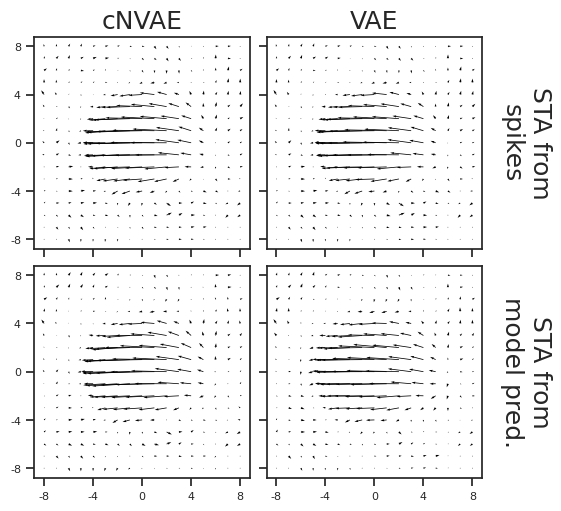

In [13]:
fig, axes = create_figure(2, 2, (5.5, 5), 'all', 'all', 'constrained')
axes[0, 0].quiver(
    span, span, stas_spk['cNVAE'][0], stas_spk['cNVAE'][1],
    scale=None,
)
axes[1, 0].quiver(
    span, span, stas_model['cNVAE'][0], stas_model['cNVAE'][1],
    scale=None,
)
axes[0, 1].quiver(
    span, span, stas_spk['VAE'][0], stas_spk['VAE'][1],
    scale=None,
)
axes[1, 1].quiver(
    span, span, stas_model['VAE'][0], stas_model['VAE'][1],
    scale=None,
)
axes[0, 0].set_title('cNVAE', fontsize=18)
axes[0, 1].set_title('VAE', fontsize=18)

ax_twix = axes[0, 1].twinx()
ax_twix.set_ylabel('STA from\nspikes', rotation=-90, fontsize=18, labelpad=50)
remove_ticks(ax_twix)

ax_twix = axes[1, 1].twinx()
ax_twix.set_ylabel('STA from\nmodel pred.\n', rotation=-90, fontsize=18, labelpad=50)
remove_ticks(ax_twix)

for ax in axes.flat:
    ax.set(
        xticks=ticks,
        yticks=ticks,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
    )
    ax.tick_params(labelsize=8)

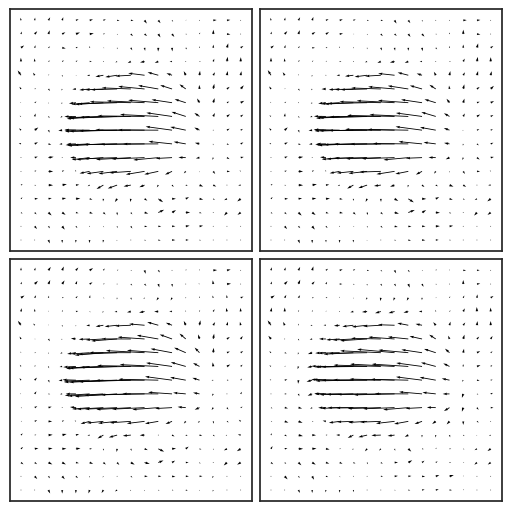

In [17]:
fig, axes = create_figure(2, 2, (5.0, 5.0), 'all', 'all', 'constrained')
axes[0, 0].quiver(
    span, span, stas_spk['cNVAE'][0], stas_spk['cNVAE'][1],
    scale=None,
)
axes[1, 0].quiver(
    span, span, stas_model['cNVAE'][0], stas_model['cNVAE'][1],
    scale=None,
)
axes[0, 1].quiver(
    span, span, stas_spk['VAE'][0], stas_spk['VAE'][1],
    scale=None,
)
axes[1, 1].quiver(
    span, span, stas_model['VAE'][0], stas_model['VAE'][1],
    scale=None,
)


for ax in axes.flat:
    remove_ticks(ax, False)

In [20]:
kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}
fig.savefig(pjoin(fig_base_dir, 'sta.pdf'), **kws_fig)

## Latency

In [23]:
path = pjoin(tmp_dir, 'results_combined')

fits = []
with open(pjoin(path, 'fits.txt'), 'r') as f:
    for line in f:
        if '# computer name' in line:
            continue
        fits.append(line.split('\n')[0])

In [24]:
df = []
perf = {}
for fit_name in fits:
    if 'reservoir' in fit_name:
        continue
    _df = f"summary_{fit_name}.df"
    _df = pjoin(tmp_dir, 'results_combined', _df)
    _df = pd.read_pickle(_df)
    assert len(_df) == 141
    k = _df['category'].unique().item()
    if 'vanilla' in fit_name:
        k = f"vanilla-{k}"
        _df['category'] = k
    perf[k] = _df.perf.values
    df.append(_df)
df = pd.concat(df)

In [25]:
df_best = best_fits(df)

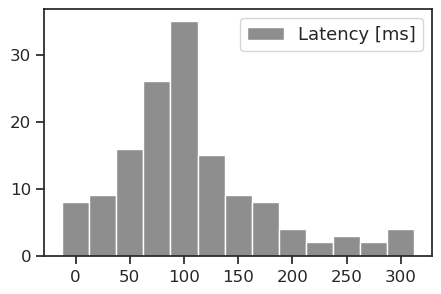

In [39]:
fig, ax = create_figure(1, 1)

sns.histplot(
    df_best['best_lag'].values,
    bins=np.linspace(0, 13, 14) - 0.5,
    label='Latency [ms]',
    color='dimgrey',
    ax=ax,
)
xticks = np.arange(0, 13, 2)
xticklabels = [i * 25 for i in xticks]
ax.set(xticks=xticks, xticklabels=xticklabels)
ax.tick_params(labelsize=12)
# ax.set_xlabel('Latency [ms]', fontsize=13)
ax.set_ylabel('')
ax.legend(fontsize=13)
plt.show()

In [40]:
kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}
fig.savefig(pjoin(fig_base_dir, 'latencies.pdf'), **kws_fig)

In [42]:
pal_model, _ = get_palette()

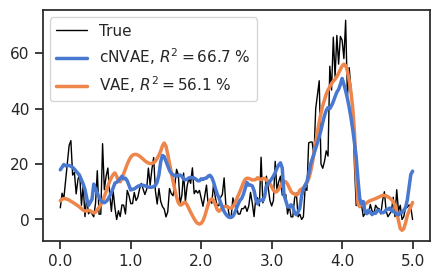

In [44]:
fig, ax = create_figure(1, 1, (5, 3))
true = v['data'][cell]['y_tst'] / 25e-3
ax.plot(true, color='k', lw=1, label='True', zorder=0)
for tag, y in preds.items():
    label = f"{tag}, " + r"$R^2 = $" + f"{r2s[tag]:0.1f} %"
    ax.plot(y / 25e-3, color=pal_model[tag], lw=2.5, label=label, zorder=zorders[tag])
xticks = [i for i in range(201) if i % 40 == 0]
ax.set(xticks=xticks, xticklabels=[i * 25e-3 for i in xticks])
# ax.set_ylabel('Firing rate [spikes/s]')
# ax.set_xlabel('Time [s]')
ax.legend()
plt.show()

In [45]:
kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}
fig.savefig(pjoin(fig_base_dir, 'psth.pdf'), **kws_fig)